# ch1_getting_started: NN Inference

In [2]:
# import package
import numpy as np
import tvm
from tvm import relay
from PIL import Image
from tvm.contrib.download import download_testdata
try:
    import torch
    import torchvision
    print("\"import torch\" success")
except:
    pass

"import torch" success


In [19]:
# Obtaining Pre-trained Models
model_name = "resnet18"
model = getattr(torchvision.models, model_name)(pretrained = True)
model = model.eval()

input_shape = [1,3,224,224]
input_data = torch.randn(input_shape)

scripted_model = torch.jit.trace(model,input_data).eval()
print(scripted_model)

ResNet(
  original_name=ResNet
  (conv1): Conv2d(original_name=Conv2d)
  (bn1): BatchNorm2d(original_name=BatchNorm2d)
  (relu): ReLU(original_name=ReLU)
  (maxpool): MaxPool2d(original_name=MaxPool2d)
  (layer1): Sequential(
    original_name=Sequential
    (0): BasicBlock(
      original_name=BasicBlock
      (conv1): Conv2d(original_name=Conv2d)
      (bn1): BatchNorm2d(original_name=BatchNorm2d)
      (relu): ReLU(original_name=ReLU)
      (conv2): Conv2d(original_name=Conv2d)
      (bn2): BatchNorm2d(original_name=BatchNorm2d)
    )
    (1): BasicBlock(
      original_name=BasicBlock
      (conv1): Conv2d(original_name=Conv2d)
      (bn1): BatchNorm2d(original_name=BatchNorm2d)
      (relu): ReLU(original_name=ReLU)
      (conv2): Conv2d(original_name=Conv2d)
      (bn2): BatchNorm2d(original_name=BatchNorm2d)
    )
  )
  (layer2): Sequential(
    original_name=Sequential
    (0): BasicBlock(
      original_name=BasicBlock
      (conv1): Conv2d(original_name=Conv2d)
      (bn1): B

(1, 3, 224, 224)


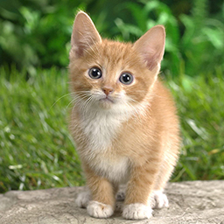

In [24]:
# Obtaining pre-processing data
img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
image = Image.open(img_path).resize((224, 224))
# image.save("./resource/cat.png")

with open("./resource/label.txt") as f:
    labels = eval(f.read())

def image_preprocessing(image):
    image = np.array(image) - np.array([123.675, 116.28, 103.53])
    image /= np.array([58.395, 57.12, 57.375])
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :]
    return image.astype('float32')
    
x = image_preprocessing(image)
print(x.shape)
image

In [40]:
# Compile Pre-trained Models

# 1.frontend framework ---> relay model
input_name = 'img'
relay_mod, relay_params = relay.frontend.from_pytorch(scripted_model, [(input_name, x.shape)])
print(type(relay_mod), type(relay_params))
# print(relay_mod, relay_params.keys())
target = 'llvm'

# 2.relay model ---> tvm.runtime.module.Module (lower() + compiler)
# lib.mod: llvm machine code -----> tvm.runtime.module.Module
# relay.build: lib ----> tvm.relay.backend.executor_factory.GraphExecutorFactoryModule
with relay.build_config(opt_level = 3):
    lib = relay.build(relay_mod, target, params = relay_params)
    graph, mod, params = lib
print(type(graph), type(mod), type(params), lib)
print(relay_mod, mod)

<class 'tvm.ir.module.IRModule'> <class 'dict'>
<class 'str'> <class 'tvm.runtime.module.Module'> <class 'dict'> <tvm.relay.backend.executor_factory.GraphExecutorFactoryModule object at 0x7fa0cd016040>
type List[A] {
  Cons(A, List[A]),
  Nil,
}

type Option[A] {
  Some(A),
  None,
}

type Tree[A] {
  Rose(A, List[Tree[A]]),
}

type tensor_float16_t {
  tensor_nil_float16,
  tensor0_float16(float16),
  tensor1_float16(Tensor[(?), float16]),
  tensor2_float16(Tensor[(?, ?), float16]),
  tensor3_float16(Tensor[(?, ?, ?), float16]),
  tensor4_float16(Tensor[(?, ?, ?, ?), float16]),
  tensor5_float16(Tensor[(?, ?, ?, ?, ?), float16]),
  tensor6_float16(Tensor[(?, ?, ?, ?, ?, ?), float16]),
}

type tensor_float32_t {
  tensor_nil_float32,
  tensor0_float32(float32),
  tensor1_float32(Tensor[(?), float32]),
  tensor2_float32(Tensor[(?, ?), float32]),
  tensor3_float32(Tensor[(?, ?, ?), float32]),
  tensor4_float32(Tensor[(?, ?, ?, ?), float32]),
  tensor5_float32(Tensor[(?, ?, ?, ?, ?), floa

/tmp/ipykernel_13040/2690994041.py:14: DeprecationWarning: legacy graph executor behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_executor.GraphModule for the  new recommended usage.
  graph, mod, params = lib


In [42]:
# Inference
from tvm.contrib import graph_executor
print(lib.__dict__.keys(), type(lib))
ctx = tvm.cpu()
rt = graph_executor.GraphModule(lib['default'](ctx))
# rt -----> tvm.contrib.graph_executor.GraphModule
print(type(mod), mod)

rt.set_input(input_name, tvm.nd.array(x))
rt.run()

scores = rt.get_output(0).asnumpy()[0]
print(scores.shape)

ans = np.argsort(scores)[-1: -5: -1]
print(labels[ans[0]], '\n', labels[ans[1]])


dict_keys(['ir_mod', 'target', 'executor', 'module', 'graph_json', 'lib', 'libmod_name', 'params', 'iter_cnt', 'function_metadata']) <class 'tvm.relay.backend.executor_factory.GraphExecutorFactoryModule'>
<class 'tvm.runtime.module.Module'> Module(llvm, 55b62e66f8c8)
(1000,)
tabby, tabby cat 
 tiger cat


In [46]:
# Saving the compiled Library
!rm -rf ./results/resnet18*

mod_name = './results/resnet18'
graph_fn, mod_fn, params_fn = [mod_name + ext for ext in ('.json', '.tar', '.params')]
print(graph_fn)
mod.export_library(mod_fn)
with open(graph_fn, 'w') as f:
    f.write(graph)
with open(params_fn, 'wb') as f:
    f.write(relay.save_param_dict(params))
    
!ls -alht ./results/resnet18*


./results/resnet18.json
-rw-r--r-- 1 qiaoliang staff  45M Oct 24 11:17 ./results/resnet18.params
-rw-r--r-- 1 qiaoliang staff  35K Oct 24 11:17 ./results/resnet18.json
-rw-r--r-- 1 qiaoliang staff 139K Oct 24 11:17 ./results/resnet18.tar


In [60]:
# Reload the saved module
loaded_graph = open(graph_fn).read()
loaded_mod = tvm.runtime.load_module(mod_fn)
loaded_params = open(params_fn, 'rb').read()
loaded_rt = graph_executor.create(loaded_graph, loaded_mod, ctx)
loaded_rt.load_params(loaded_params)
loaded_rt.set_input(input_name, tvm.nd.array(x))
loaded_rt.run()
loaded_scores = loaded_rt.get_output(0).asnumpy()[0]
loaded_scores = np.argsort(loaded_scores)[-1:-5:-1]

print(labels[loaded_scores[0]], '\n', labels[loaded_scores[1]])


tabby, tabby cat 
 tiger cat


# Summary
We can use relay of TVM to convert and compile a neural network into a module for model inference

We can save the compiled module into disk to facilitate future deployment.